In [1]:
from prf import *
import scipy.signal as sp
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
from matplotlib.widgets import Slider, Button
from scipy.interpolate import interp2d
import cv2

In [2]:
'''
Stims shape = [x, y, t, c, n] for each condition (perception, LTM, WM)
x = size
y = size
t = time points
c = cortical roi
n = number of positions
'''

size = 100
n_time = 5
n_pos = 4
target_ecc = 7
near_ecc = 1.5

v1slope = 0.23
v2slope = 0.3
v3slope = 0.39
v4slope = 0.56
slopes = [v1slope, v2slope, v3slope, v4slope]
intercept = 0.6
n_ecc = 20

origin = np.array([size/2, size/2])
radius = np.sqrt(((size/2.0)**2.0)+((size/2.0)**2.0))

n_bins = 30
all_vox = False

# Generate voxels and pRFs
v1 = generate_voxels(n_eccentricities = n_ecc, prf_slope = v1slope, prf_intercept = intercept)
v2 = generate_voxels(n_eccentricities = n_ecc, prf_slope = v2slope, prf_intercept = intercept)
v3 = generate_voxels(n_eccentricities = n_ecc, prf_slope = v3slope, prf_intercept = intercept)
v4 = generate_voxels(n_eccentricities = n_ecc, prf_slope = v4slope, prf_intercept = intercept)

cortex = [v1, v2, v3, v4]
n_regions = len(cortex)
n_voxels = len(v1)
cortex_prfmaps = np.zeros([size, size, n_voxels, len(cortex)])

for c, region in enumerate(cortex):
    for i, v in enumerate(region):
        x, y, ecc, prf_size = v
        cortex_prfmaps[:, :, i, c] = generate_prf(center = [x, y], size = size, sd = prf_size)
        

# Initialize source matrices
perception = np.zeros([size, size, n_time, n_regions, n_pos])
LTM = np.zeros(perception.shape)
WM = np.zeros(perception.shape)

# Initialize response matrices
if all_vox == False: 
    n_voxels = len(np.where((v1[:, 2] <= target_ecc + near_ecc) & \
                            (v1[:, 2] >= target_ecc - near_ecc))[0])

perc_resp = np.zeros([n_voxels, 6, n_pos, n_regions, n_time])
LTM_resp = np.zeros(perc_resp.shape)
WM_resp = np.zeros(perc_resp.shape)

# Initialize PARF matrices
perc_parf = np.zeros([n_bins-1, 2, n_regions, n_time])
LTM_parf = np.zeros(perc_parf.shape)
WM_parf = np.zeros(perc_parf.shape)

# Generate stimuli
stims, positions, angles = generate_isostim(target_ecc, n_pos, size = size)

In [3]:
'''
Generate "SOURCE" Images

Why might LTM be biased towards encoding eccentricity (lower variance in logpolar filter along eccentricity)?

Conversely, why might WM be biased towards encoding polar angle (lower variance in logpolar filter along polar angle)?

Potentially, it could be task AND source based. LTM condition is trained in a pre-scan task. 
When training, the task has higher variance along polar angle than along eccentricity, since all learned stimuli are at fixed eccentricity. 
Therefore, it is likely that subject errors in recall will be a result of varaince in encoding of polar angle, since stimuli are isoeccentric.

Conversely, WM is not learned prior, it is shown immediately before the delay.
Since there are no other locations/maskers, the variance in maintenance of polar angle should be small.
Variance in eccentricity might also be small due to task being isoeccentric.

'''

for t in range(n_time):
    print(t)
    for c in range(n_regions):
        # LTM
        sd = 8 - c
        filt = generate_prf_warp(size = size/2, sd = sd, y_warp = 0.9, x_warp = 1.5) 
        LTM[:, :, t, c, :] = gen_polarstims(stims, filt, origin, radius, space = 'log')  * (1 - slopes[c]) / (t+1)
        
        # WM
        sd = (t+1)*2
        filt = generate_prf_warp(size = size/2, sd = sd, y_warp = 1.5, x_warp = 1)
        WM[:, :, t, c, :] = gen_polarstims(stims, filt, origin, radius, space = 'log') * (1 - slopes[c])/ (t+1)
        
        # Perception
        perception[:, :, t, c, :] = stims


0
1
2
3
4


Text(0.05, 0.33, 'WM')

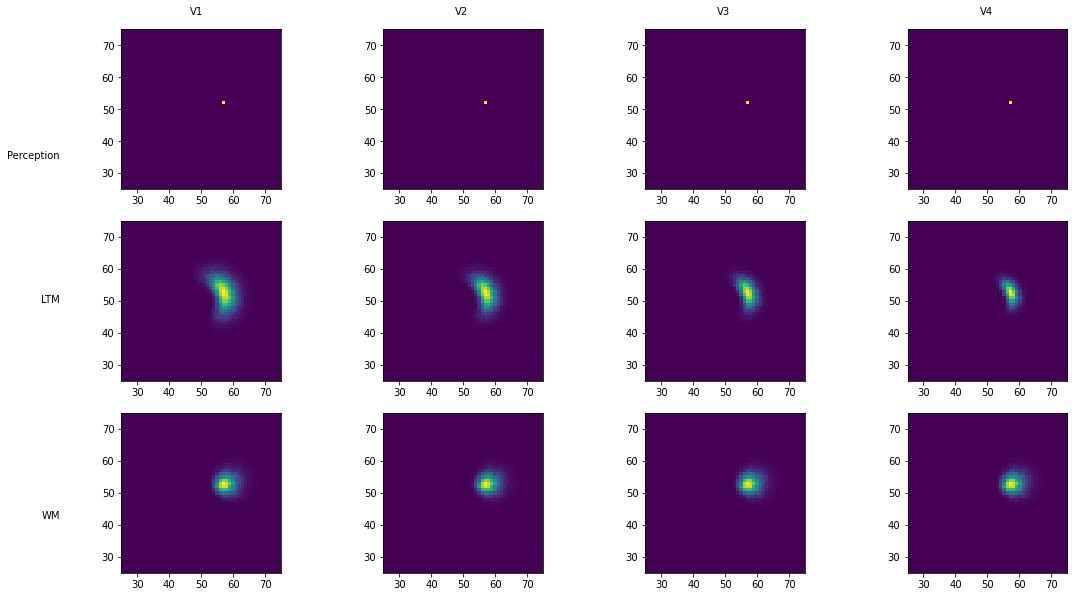

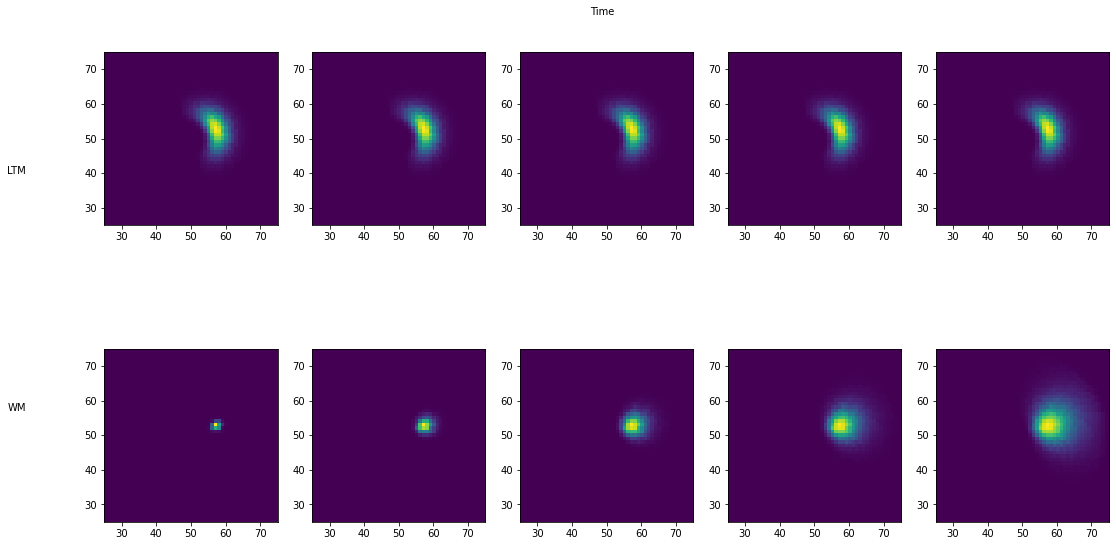

In [4]:
'''
Plot "SOURCE" Images
'''
zoom = 2
fig, axs = plt.subplots(3, n_regions)
fig.set_size_inches(18, 10)

z = size/(zoom*2)
t = 2

for c in range(n_regions):        
        axs[0, c].imshow(perception[:, :, t, c, 0])
        axs[0, c].set_ylim([size/2 - z, size/2 + z])
        axs[0, c].set_xlim([size/2 - z, size/2 + z])
        
        axs[1, c].imshow(LTM[:, :, t, c, 0])
        axs[1, c].set_ylim([size/2 - z, size/2 + z])
        axs[1, c].set_xlim([size/2 - z, size/2 + z])
        
        axs[2, c].imshow(WM[:, :, t, c, 0])
        axs[2, c].set_ylim([size/2 - z, size/2 + z])
        axs[2, c].set_xlim([size/2 - z, size/2 + z])
        

fig.text(0.1, 0.2, 'WM', ha = 'right')
fig.text(0.1, 0.5, 'LTM', ha = 'right')
fig.text(0.1, 0.7, 'Perception', ha = 'right')

fig.text(0.2, 0.9, 'V1')
fig.text(0.405, 0.9, 'V2')
fig.text(0.607, 0.9, 'V3')
fig.text(0.81, 0.9, 'V4')


fig, axs = plt.subplots(2, n_time)
fig.set_size_inches(18, 10)
c = 0
for t in range(n_time):
        axs[0, t].imshow(LTM[:, :, t, c, 0])
        axs[0, t].set_ylim([size/2 - z, size/2 + z])
        axs[0, t].set_xlim([size/2 - z, size/2 + z])
        
        axs[1, t].imshow(WM[:, :, t, c, 0])
        axs[1, t].set_ylim([size/2 - z, size/2 + z])
        axs[1, t].set_xlim([size/2 - z, size/2 + z])

fig.text(0.5, 0.88, 'Time')
fig.text(0.05, 0.66, 'LTM')
fig.text(0.05, 0.33, 'WM')

In [5]:
'''
Compute prfResponses
'''
for c in range(n_regions):
    prf_maps = cortex_prfmaps[:, :, :, c]
    voxels = cortex[c]
    print(c)
    for t in range(n_time):
        P_sources = perception[:, :, t, c, :]
        L_sources = LTM[:, :, t, c, :]
        W_sources = WM[:, :, t, c, :]

        perc_resp[:, :, :, c, t] = gen_pRFresponses(near_ecc, target_ecc, P_sources, prf_maps, voxels, positions, all_vox = all_vox).squeeze()
        LTM_resp[:, :, :, c, t] = gen_pRFresponses(near_ecc, target_ecc, L_sources, prf_maps, voxels, positions, all_vox = all_vox).squeeze()
        WM_resp[:, :, :, c, t] = gen_pRFresponses(near_ecc, target_ecc, W_sources, prf_maps, voxels, positions, all_vox = all_vox).squeeze()

0
1
2
3


In [6]:
'''
Compute Polar Angle Response Functions
'''

for c in range(n_regions):
    for t in range(n_time):
        perc_parf[:, :, c, t] = parf_tuningcurve(n_bins, perc_resp[:, :, :, c, t].squeeze())
        LTM_parf[:, :, c, t] = parf_tuningcurve(n_bins, LTM_resp[:, :, :, c, t].squeeze())
        WM_parf[:, :, c, t] = parf_tuningcurve(n_bins, WM_resp[:, :, :, c, t].squeeze())
        
        

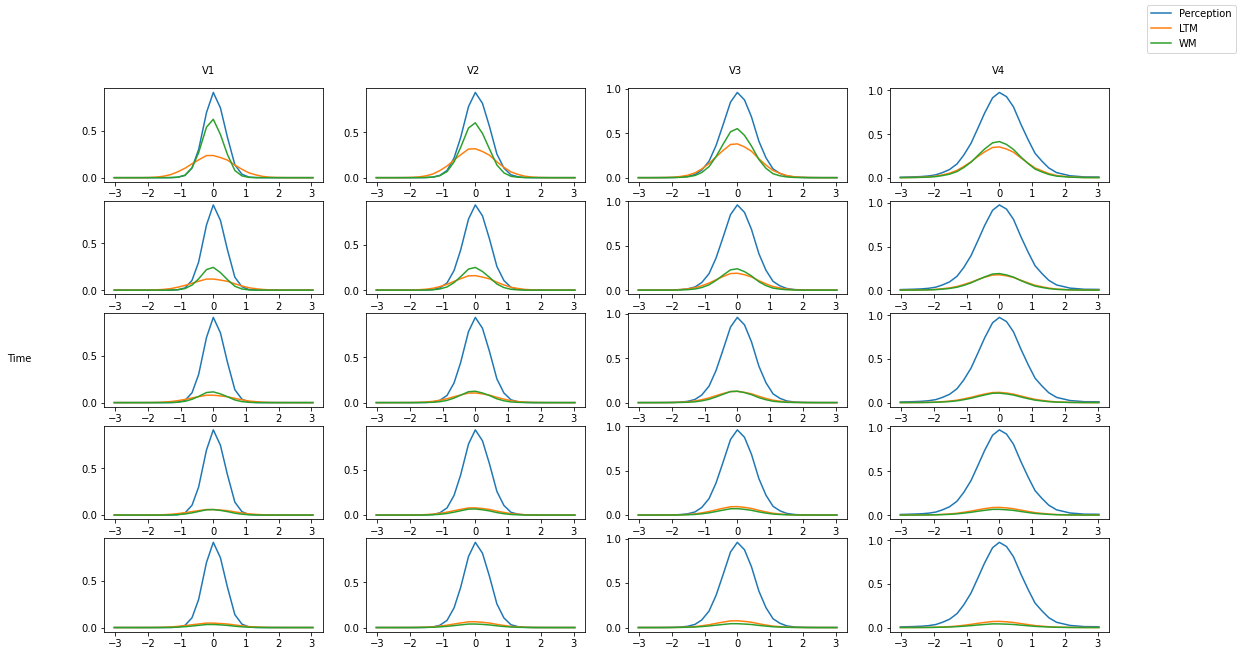

In [7]:
'''
Plot Simulations
'''
fig, axs = plt.subplots(n_time, n_regions)
fig.set_size_inches(18, 10)

for c in range(n_regions):
    for t in range(n_time):
        ax = axs[t, c]
        ax.plot(perc_parf[:, 0, c, t], perc_parf[:, 1, c, t])
        ax.plot(LTM_parf[:, 0, c, t], LTM_parf[:, 1, c, t])
        ax.plot(WM_parf[:, 0, c, t], WM_parf[:, 1, c, t])
        
fig.text(0.05, 0.5, 'Time')
fig.text(0.2, 0.9, 'V1')
fig.text(0.405, 0.9, 'V2')
fig.text(0.607, 0.9, 'V3')
fig.text(0.81, 0.9, 'V4')
fig.legend(['Perception', 'LTM', 'WM'])

In [17]:
'''
Compute FWHM & Amplitude
'''
n_conds = 3
fwhm_summary = np.zeros([n_conds, n_regions, n_time])
amp_summary = np.zeros(fwhm_summary.shape)

for c in range(n_regions):
    for t in range(n_time):
        
        fwhm_summary[0, c, t], amp_summary[0, c, t], _, _ = sp.peak_widths(perc_parf[:, 1, c, t], sp.find_peaks(perc_parf[:, 1, c, t])[0])
        fwhm_summary[1, c, t], amp_summary[1, c, t], _, _ = sp.peak_widths(LTM_parf[:, 1, c, t], sp.find_peaks(LTM_parf[:, 1, c, t])[0])
        fwhm_summary[2, c, t], amp_summary[2, c, t], _, _ = sp.peak_widths(WM_parf[:, 1, c, t], sp.find_peaks(WM_parf[:, 1, c, t])[0])
        
amp_summary *= 2



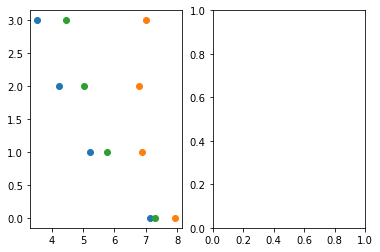

In [56]:
'''
Plot FWHM and Amplitude Summaries
'''
fig, axs = plt.subplots(1, 2)
t = 2

axs[0].scatter(fwhm_summary[0, ::-1, t], np.linspace(0, n_regions-1, n_regions))
axs[0].scatter(fwhm_summary[1, ::-1, t], np.linspace(0, n_regions-1, n_regions))
axs[0].scatter(fwhm_summary[2, ::-1, t], np.linspace(0, n_regions-1, n_regions))
# axs[0].scatter(fwhm_summary[1, :, t])
# axs[0].scatter(fwhm_summary[2, :, t])

In [13]:
sp.peak_widths(perc_parf[:, 1, 0, 0], sp.find_peaks(perc_parf[:, 1, 0, 0])[0])

(array([3.53407226]),
 array([0.4555099]),
 array([12.39291714]),
 array([15.9269894]))

In [9]:
perc_parf[:, 1, 0, 0]

array([1.62826357e-09, 4.56041199e-09, 9.80656127e-09, 3.43405118e-08,
       1.52144722e-07, 1.06346381e-06, 8.24569942e-06, 7.03279921e-05,
       5.94898576e-04, 4.10044703e-03, 2.36455701e-02, 1.04759038e-01,
       2.99900961e-01, 6.95935953e-01, 9.11019788e-01, 7.45886088e-01,
       4.32639581e-01, 1.37889390e-01, 3.65449399e-02, 5.82709202e-03,
       1.04368969e-03, 1.29088835e-04, 1.07799228e-05, 2.13330462e-06,
       2.21035924e-07, 4.92526270e-08, 9.23190602e-09, 5.01261282e-09,
       3.74375432e-09])

In [12]:
sp.find_peaks(perc_parf[:, 1, 0, 0])[0]

array([14])

In [24]:
np.arange(4, 0, -1)

array([4, 3, 2, 1])

In [35]:
fwhm_summary[0, :, t]

array([3.53407226, 4.23392559, 5.20911938, 7.1451872 ])

In [38]:
np.arange(n_regions)

array([0, 1, 2, 3])

In [43]:
np.linspace(0, n_regions-1, 4)

array([0., 1., 2., 3.])

In [47]:
np.linspace(n_regions-1, 0, 4)

array([3., 2., 1., 0.])